[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/analytics-and-ml/model-training/classifier-train-vector-search/00-indexer-clip.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/analytics-and-ml/model-training/classifier-train-vector-search/00-indexer-clip.ipynb)

In [ ]:
!pip install datasets transformers pinecone-client tqdm

In [1]:
from datasets import load_dataset

imagenet = load_dataset(
    'frgfm/imagenette',
    'full_size',
    split='train',
    ignore_verifications=False  # set to True if seeing splits Error
)
imagenet

Reusing dataset imagenette (/home/jupyter/.cache/huggingface/datasets/frgfm___imagenette/full_size/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)


Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

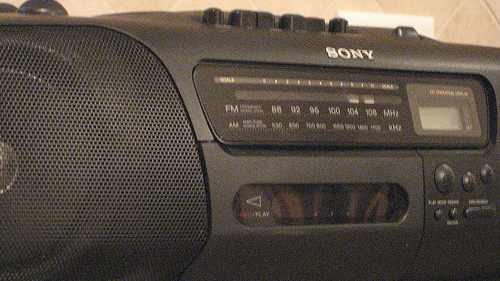

In [2]:
# important to use imagenet[0]['image'] rather than imagenet['image'][0]
# as the latter loads the entire image column then extracts index 0
# whereas the former extracts record 0 and then retrieves the ['image']
imagenet[0]['image']

In [3]:
import numpy as np

img = np.array(imagenet[0]['image'])
img.shape

(281, 500, 3)

We need to use these images to create vector embeddings, to do this we will use OpenAI's CLIP from the `transformers` library.

```
!pip install transformers
```

In [4]:
from transformers import CLIPProcessor, CLIPModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "openai/clip-vit-base-patch32"

model = CLIPModel.from_pretrained(model_id).to(device)
processor = CLIPProcessor.from_pretrained(model_id)

2022-07-28 17:25:04.418367: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Now we're ready to use the resnet-50 portion of CLIP to create feature vectors (embedding representations) from the image.

In [5]:
image = processor(
    text=None,
    images=imagenet[0]['image'],
    return_tensors='pt',
    padding=True
)['pixel_values'].to(device)

In [6]:
out = model.get_image_features(pixel_values=image)
out.shape

torch.Size([1, 512])

In [7]:
out = out.squeeze(0)
out.shape

torch.Size([512])

In [8]:
emb = out.cpu().detach().numpy()
emb.shape

(512,)

In [9]:
emb.min(), emb.max()

(-5.8449764, 1.3772836)

Now we have a single `512` dimensional vector that represents the *meaning* behind the image. As we will be using dot product similarity we should also normalize these vectors.

In [10]:
emb = emb / np.linalg.norm(emb)

In [11]:
emb.min(), emb.max()

(-0.56626415, 0.13343191)

## Indexing

To index this image in Pinecone we first install the Pinecone client:

```
!pip install pinecone-client
```

And then initialize our connection to Pinecone, this requires a [free API key](https://app.pinecone.io/).

In [12]:
from pinecone import Pinecone

index_name = "imagenet-query-trainer-clip"

pinecone.init(
    api_key="YOUR_API_KEY",
    environment="YOUR_ENV"  # find next to API key in console
)

if index_name not in pinecone.list_indexes().names():
    pinecone.create_index(
        index_name,
        emb.shape[0],
        metric="dotproduct",
        metadata_config={"indexed": ["seen"]}
    )
# connect to the index
index = pinecone.Index(index_name)

To upsert the single feature embedding we have created, we use `upsert`:

In [13]:
to_upsert = [("0", emb.tolist())]

index.upsert(to_upsert)

{'upserted_count': 1}

Note that we added a string ID value `"0"` and also converted the feature embedding tensor to a flat list before adding to our Pinecone index.

## Indexing Everything

So far we've built one feature embedding and indexed it in Pinecone, now let's repeat the process for a lot of images.

We will do this in batches, taking `32` images at a time, embedding them with Resnet-50, and indexing them in Pinecone.

In [15]:
from tqdm.auto import tqdm
batch_size = 64

for i in tqdm(range(0, len(imagenet), batch_size)):
    # select the batch start and end
    i_end = min(i + batch_size, len(imagenet))
    # some images are grayscale (mode=='L') we only keep 'RGB' images
    images = [img for img in imagenet[i:i_end]['image'] if img.mode == 'RGB']
    # process images and extract pytorch tensor pixel values
    image = processor(
        text=None,
        images=images,
        return_tensors='pt',
        padding=True
    )['pixel_values'].to(device)
    # feed tensors to model and extract last state
    out = model.get_image_features(pixel_values=image)
    out = out.squeeze(0)
    # convert to a numpy array
    embeds = out.cpu().detach().numpy()
    # normalize and convert to list
    embeds = embeds / np.linalg.norm(embeds, axis=0)
    embeds = embeds.tolist()
    # create ID values
    ids = [str(i) for i in range(i, i_end)]
    # prep metadata
    meta = [{'seen': 0} for image in images]
    # zip all data together and upsert
    to_upsert = zip(ids, embeds, meta)
    index.upsert(to_upsert)

  0%|          | 0/148 [00:00<?, ?it/s]

We can now query given an image, like this of a radio:

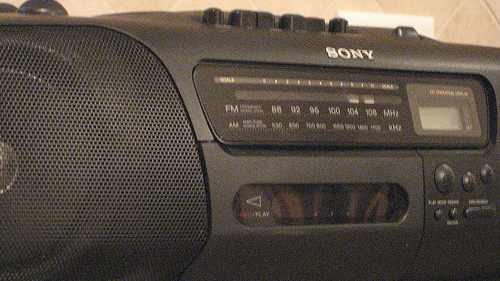

In [16]:
imagenet[0]['image']

In [17]:
image = processor(
    text=None,
    images=[imagenet[0]['image']],
    return_tensors='pt',
    padding=True
)['pixel_values'].to(device)
out = model.get_image_features(pixel_values=image)
out = out.squeeze(0)
xq = out.cpu().detach().numpy()
# normalize
xq = xq / np.linalg.norm(xq)
xq = xq.tolist()

res = index.query(vector=xq, top_k=5)

In [18]:
res

{'matches': [{'id': '0', 'score': 2.2550683, 'values': []},
             {'id': '571', 'score': 1.7217741, 'values': []},
             {'id': '20', 'score': 1.70724881, 'values': []},
             {'id': '978', 'score': 1.63423467, 'values': []},
             {'id': '935', 'score': 1.49153423, 'values': []}],
 'namespace': ''}

In [19]:
matches = [imagenet[int(match['id'])]['image'] for match in res['matches']]

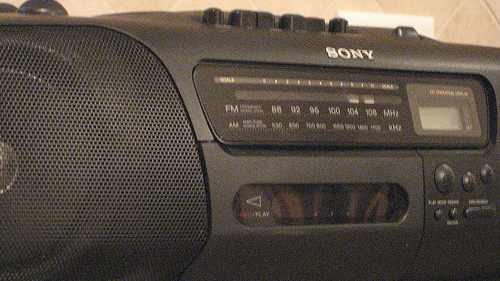

In [20]:
matches[0]

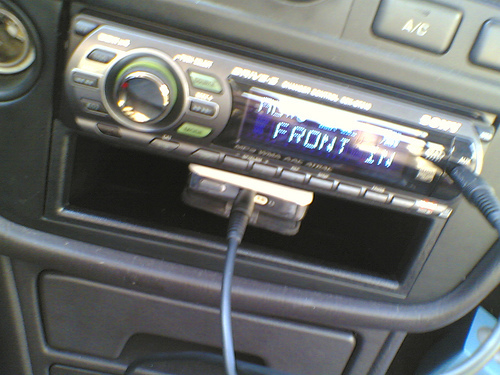

In [21]:
matches[1]

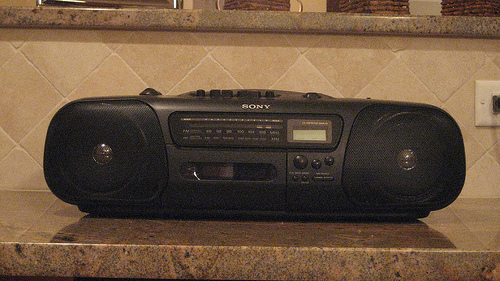

In [22]:
matches[2]

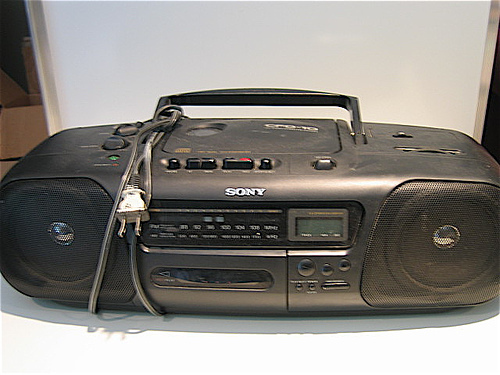

In [23]:
matches[3]

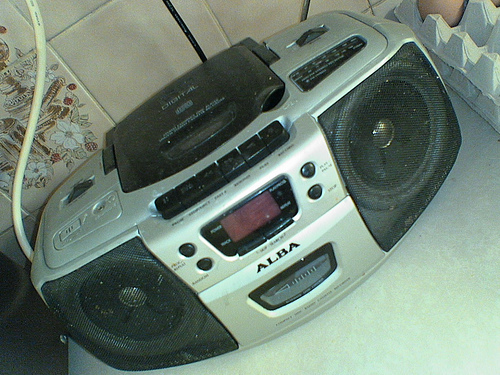

In [24]:
matches[4]

That's pretty impressive, it even manages to return the exact same radio model from different angles and lighting conditions.

Let's try another image...

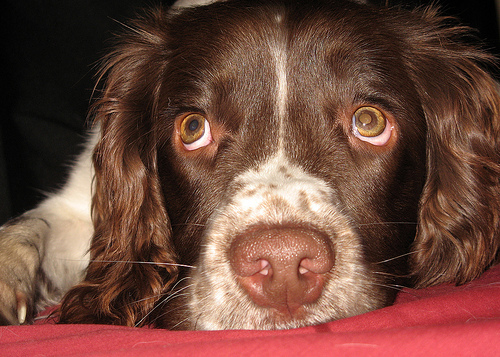

In [25]:
imagenet[5802]['image']

In [29]:
image = processor(
    text=None,
    images=[imagenet[5802]['image']],
    return_tensors='pt',
    padding=True
)['pixel_values'].to(device)
out = model.get_image_features(pixel_values=image)
out = out.squeeze(0)
xq = out.cpu().detach().numpy()
# normalize
xq = xq / np.linalg.norm(xq)
xq = xq.tolist()

res = index.query(vector=xq, top_k=5)

matches = [imagenet[int(match['id'])]['image'] for match in res['matches']]

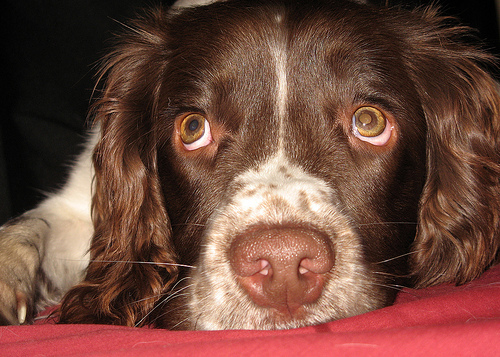

In [30]:
matches[0]

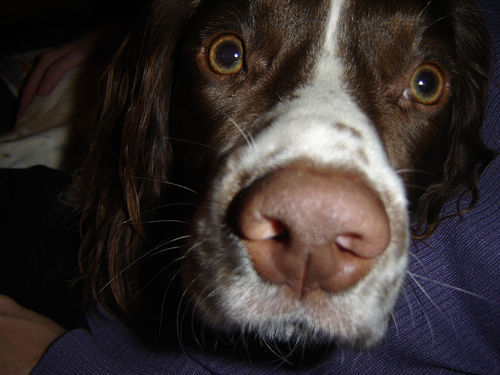

In [31]:
matches[1]

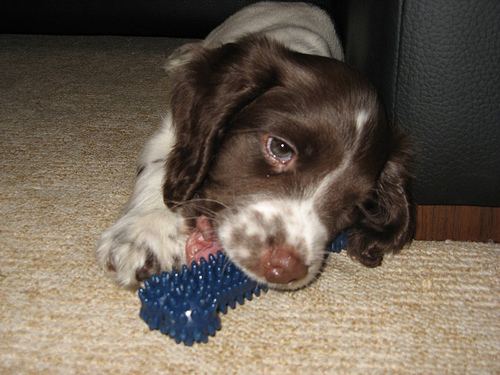

In [32]:
matches[2]

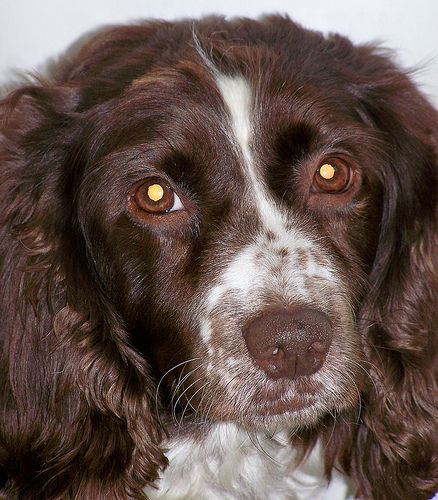

In [33]:
matches[3]

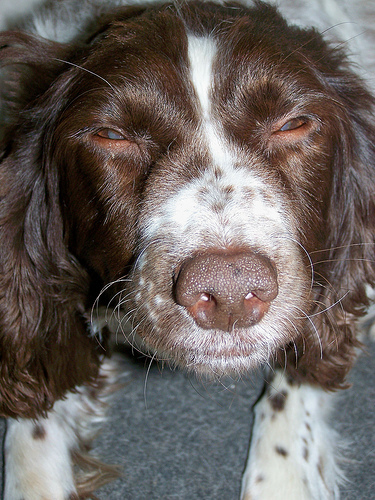

In [34]:
matches[4]

These results are excellent and show that our embedding and indexing is working as expected.

---